In [ ]:
import kagglehub
import albumentations as A
import glob
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import gc
import requests
import zipfile


from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torchvision.models as models
from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet50_Weights
from torch.nn.functional import binary_cross_entropy_with_logits
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Donwload dataset

1. LoveDA Dataset
- Zenodo link: https://zenodo.org/records/16839878
- Direct download link: https://zenodo.org/api/records/16839878/files/LoveDA_Forests.zip/content
- This dataset contains 377 images with a resolution of 0.3m/pixel.
- This cell will download the dataset from Zenodo

In [ ]:
# Download zip
url = "https://zenodo.org/api/records/16839878/files/LoveDA_Forests.zip/content"
output_file = "/content/Loveda_forest.zip"
response = requests.get(url, stream=True)
with open(output_file, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Unzip
extract_path = "/content"
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
train_data_path = "/content/LoveDA_Forests"

## Create a dataset class and define the transformations
- The class object will keep a list of images, we can access the images through their index

In [ ]:
# Transformations for images and masks
img_transforms = A.Compose([
    A.Resize(height=512,width=512),
    A.RandomResizedCrop(size=(512,512),scale=(0.4,1), ratio=(0.4,1),p=0.8),
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.15, hue=0.15),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
])

# Dataset class for LoveDA dataset
class CustomDataset_LOVEDA(Dataset):
    def __init__(self, path):
        img_type = "png"
        mask_type = "png"
        # Find img paths
        img_path = os.path.join(path,"IMGS")
        img_path_list = glob.glob(str(Path(img_path)/"**"/f"*.{img_type}"),recursive=True)
        label_path_list = [path.replace("IMGS","MASKS").replace(img_type,mask_type) for path in img_path_list]
        self.img_path_list = img_path_list
        self.label_path_list = label_path_list

    def __getitem__(self, index):
        """
        - Given an index, return the corresponding img and mask.
        - This function will be called when we want to get an item from the dataset
        - Example: CustomDataset_JORDAN(/path_to_dataset)[0] -> calls this function and returns first img and mask
            Args:
                index (int)
            Returns:
                img (torch.tensor)
                mask/label (torch.tensor)
        """
        # Read img
        img = np.array(cv2.imread(self.img_path_list[index]))
        # Read mask
        # The original masks contain 8 category labels, we only want 2 categories: Forests(6), Non-Forests(0,1,2,3,4,5,7):
        label = (cv2.imread(self.label_path_list[index],cv2.IMREAD_GRAYSCALE)==6).astype(np.uint8)/1.0
        label = np.expand_dims(label, axis=2) # Add an extra dimension (channels) to labels
        # Apply transformation to both img and mask
        augmented = img_transforms(image=img, mask=label)
        # Extract imgs and mask, transform them to tensor, apply transpose to convert the dimensions to (channels,height,width)
        img = torch.tensor(np.transpose(augmented["image"],(2,0,1)),dtype=torch.uint8).float()/255.0
        label = torch.tensor(np.transpose(augmented["mask"],(2,0,1)),dtype=torch.uint8).float()
        return img, label

    def __len__(self):
        return len(self.img_path_list)


## Pass the dataset class to a dataloader and show some images and masks

Image_batch shape (batch dimension, channels dimension, height, width):  torch.Size([8, 3, 512, 512])
Mask_batch shape (batch dimension, channels dimension, height, width):  torch.Size([8, 1, 512, 512])


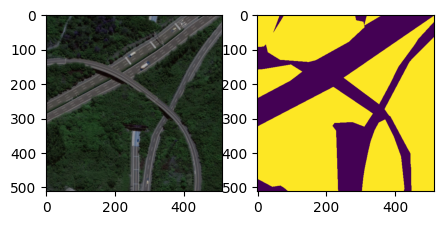

In [ ]:
# Dataset object
LoveDA_dataset = CustomDataset_LOVEDA(train_data_path)
# Dataloader
LoveDA_dataloader = DataLoader(LoveDA_dataset, batch_size=8, shuffle=True,pin_memory=True, drop_last=True)
# Check the dimensions
for idx,(img_batch,mask_batch) in enumerate(LoveDA_dataloader):
  print("Image_batch shape (batch dimension, channels dimension, height, width): ", img_batch.shape)
  print("Mask_batch shape (batch dimension, channels dimension, height, width): ", mask_batch.shape)
  break

# Show some imgs and masks
fig, axis = plt.subplots(1,2,figsize=(5,5))
for idx,(img_batch,mask_batch) in enumerate(LoveDA_dataloader):
  img = np.transpose(img_batch[0],(1,2,0)) # Convert from (channel,height,width) to (height,width,channel)
  mask = np.transpose(mask_batch[0],(1,2,0))
  axis[0].imshow(img)
  axis[1].imshow(mask)
  break




## Accelerator

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Model (DeeplabV3)
- We modified the last layer by adding a binary classification head

In [ ]:
# Deeplabv3 model
class Deeplabv3(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.deeplab = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        # forest/non-forest
        self.deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
        self.out = nn.Sigmoid()

    def forward(self, x):
        x1 = self.deeplab(x)['out']
        out = self.out(x1)
        return out

## Training setup

- Some functions

In [ ]:
def count_parameters(model_object):
  """
  Optional(Calculate the number of parameters of a model)
  Args:
    Model object
  Return:
    Number of parameters (int)
  """
  return sum(p.numel() for p in model_object.parameters() if p.requires_grad)

# Loss function to be used
def loss_fn(y_pred,y):
  """
  Calculate the loss function
  Args:
    y_pred (torch.tensor): predictions stored in a tensor
    y (torch.tensor): ground-truth values stored in a tensor
  Return:
    loss (torch.tensor): loss stored in a 1x1 tensor
  """
  return binary_cross_entropy_with_logits(y_pred,y)


- Train-test split

In [ ]:
# Train-test split (need to be done before passing to the dataloader)
LoveDA_dataset = CustomDataset_LOVEDA(train_data_path) # Dataset
train_dataset, test_dataset = torch.utils.data.random_split(LoveDA_dataset, [9/10, 1/10]) # Dataset
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,pin_memory=True, drop_last=True) # Dataloader
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True,pin_memory=True, drop_last=True) # Dataloader
print("train:", len(train_dataset))
print("test:", len(test_dataset))


train: 340
test: 37


- Initialize the model and define some parameters

In [ ]:
# Initialize the model
model = Deeplabv3().to(device)

# Leraning rate
learning_rate = 1e-4

# Number of epochs
num_epochs = 3

# Initialize the optimizer (Use Adam as optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Path to save the models
save_dir = "/content/models/"

try:
  os.makedirs(save_dir)
except:
    pass

## Model Training

In [ ]:
for epoch in range(num_epochs):
    # Training--------------------------------------------------
    epoch_loss = 0.0
    for idx, (X_batch, Y_batch) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)):
        # Load img_batch and move to gpu (if available)
        X = X_batch.to(device)
        # Load mask_batch and move to gpu
        X_mask = Y_batch
        X_mask = X_mask.to(device)
        # Reset gradient
        optimizer.zero_grad()
        # Forward
        with torch.autocast(device_type=device):
            torch.cuda.empty_cache()
            gc.collect()
            # Prediction
            X_mask_pred = model(X)
            # Compute loss
            train_loss = loss_fn(X_mask_pred, X_mask) # Loss per batch
            # Acumulate loss
            epoch_loss += train_loss.item()
        # Back propagation
        train_loss.backward()
        optimizer.step()
        # Print loss for current batch
        if idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{idx}/{len(train_dataloader)}], Train Loss: {train_loss.item():.4f}")
        # Clean cache
        torch.cuda.empty_cache()
        gc.collect()
    # Print average loss for current epoch
    print(f"Epoch {epoch+1} - Average Train Loss: {epoch_loss / len(train_dataloader):.4f}")


    # Testing--------------------------------------------------
    with torch.no_grad():
        epoch_test_loss = 0.0
        epoch_test_acc = 0.0
        for idx, (X_batch, Y_batch) in enumerate(test_dataloader):
            # Load img_batch and move to gpu (if available)
            X = X_batch
            X = X.to(device)
            # Load mask_batch and move to gpu
            X_mask = Y_batch
            X_mask = X_mask.to(device)
            with torch.autocast(device_type=device):
                torch.cuda.empty_cache()
                gc.collect()
                # Prediction
                X_mask_pred = model(X)
                # Compute loss
                test_loss = loss_fn(X_mask_pred, X_mask) # Loss per batch
                # Acumulate loss
                epoch_test_loss += test_loss.item()

            # To compute the accuracy, convert the prediction output into binary format:
            threshold = 0.5
            X_mask_pred_bin_flatten = np.where(X_mask_pred.cpu().detach().numpy()>threshold,1,0).flat
            X_mask_flatten = Y_batch.cpu().detach().numpy().flat
            # Compute accuracy
            test_acc = accuracy_score(X_mask_pred_bin_flatten,X_mask_flatten) # acc per batch
            # Acumulate accuracy
            epoch_test_acc += test_acc
    print(f"Epoch {epoch+1}, Average Test Accuracy: {epoch_test_acc/len(test_dataloader)*100:.4f}%")
    print(f"Epoch {epoch+1}, Average Test Loss: {epoch_test_loss/len(test_dataloader):.4f}")

    # Conditions to save the model:
    # Adjust this part according to your needs (like adding early stopping)
    test_accuracy = epoch_test_acc/len(test_dataloader)
    if (test_accuracy>=0.9) or (epoch % 10 == 0):
      model_name = f"DeeplabV3_{test_accuracy:.3f}_{epoch}.pt"
      save_path = os.path.join(save_dir,model_name)
      torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "Train loss": epoch_loss / len(train_dataloader),
        "Test loss": epoch_test_loss/len(test_dataloader),
        "Test accuracy": test_accuracy,
        }, save_path)

Epoch 1/3:   0%|                                                             | 0/85 [00:00<?, ?it/s]

Epoch [1/3], Batch [0/85], Train Loss: 0.5980


Epoch 1/3: 100%|████████████████████████████████████████████████████| 85/85 [03:02<00:00,  2.15s/it]


Epoch 1 - Average Train Loss: 0.5638
Epoch 1, Average Test Accuracy: 80.4109%
Epoch 1, Average Test Loss: 0.5293


Epoch 2/3:   0%|                                                             | 0/85 [00:00<?, ?it/s]

Epoch [2/3], Batch [0/85], Train Loss: 0.5836


Epoch 2/3: 100%|████████████████████████████████████████████████████| 85/85 [03:03<00:00,  2.16s/it]


Epoch 2 - Average Train Loss: 0.5403
Epoch 2, Average Test Accuracy: 72.7371%
Epoch 2, Average Test Loss: 0.5540


Epoch 3/3:   0%|                                                             | 0/85 [00:00<?, ?it/s]

Epoch [3/3], Batch [0/85], Train Loss: 0.5171


Epoch 3/3: 100%|████████████████████████████████████████████████████| 85/85 [02:59<00:00,  2.11s/it]


Epoch 3 - Average Train Loss: 0.5491
Epoch 3, Average Test Accuracy: 82.9853%
Epoch 3, Average Test Loss: 0.5172


### Prediction

In [ ]:
img_dir = "/content/LoveDA_Forests/IMGS"
img_path_list = glob.glob(str(Path(img_dir)/"*.png"))
mask_path_list = [path.replace("IMGS","MASKS") for path in img_path_list]
# Put the model to prediction mode
model.eval().to(device)

Deeplabv3(
  (deeplab): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [ ]:
# Load and predict
original_img_list = []
original_mask_list = []
predicted_mask_list = []

for idx, img_path in enumerate(img_path_list):
  # Load images and ground-truth masks
  original_img = cv2.imread(img_path)/255.0
  original_img_list.append(original_img)
  original_mask = (cv2.imread(mask_path_list[idx],cv2.IMREAD_GRAYSCALE)==6).astype(np.uint8)/1.0
  original_mask_list.append(original_mask)

  # Conversion to tensor
  img = cv2.resize(original_img,(512,512))
  img = np.transpose(img,(2,0,1))
  img = np.expand_dims(img,axis=0) # add batch dimension
  img_tensor = torch.tensor(img).float().to(device)
  # Prediction
  mask = model(img_tensor).detach().cpu().squeeze(0)
  # Apply threshold
  mask = np.array(np.transpose(mask,(1,2,0)))
  mask = np.where(cv2.resize(mask,(1024,1024))>0.5,1,0).astype(np.uint8)
  predicted_mask_list.append(mask)
  if idx > 1:
    break

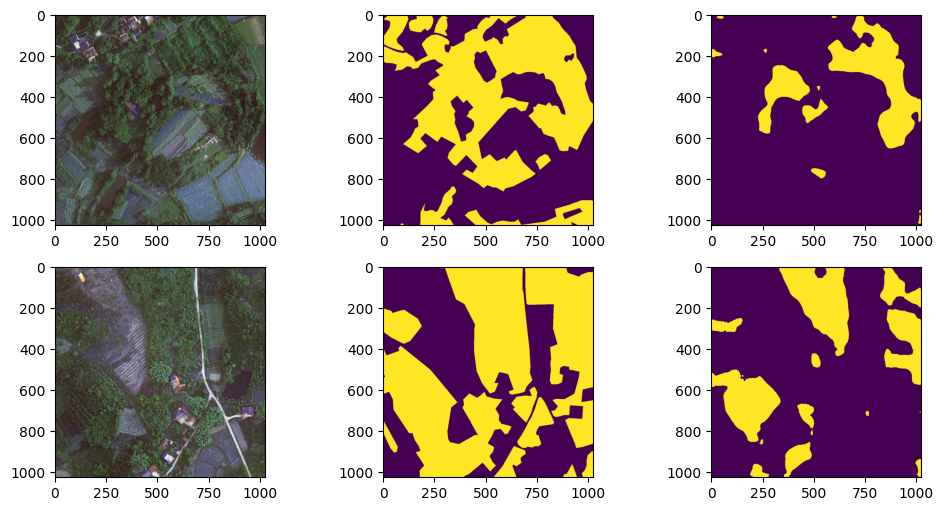

In [ ]:
fig, axis = plt.subplots(2,3,figsize=(12,6))
axis[0,0].imshow(original_img_list[0])
axis[1,0].imshow(original_img_list[1])
axis[0,1].imshow(original_mask_list[0])
axis[1,1].imshow(original_mask_list[1])
axis[0,2].imshow(predicted_mask_list[0])
axis[1,2].imshow(predicted_mask_list[1])


# del original_img_list, original_mask_list, predicted_mask_list
# gc.collect()
# torch.cuda.empty_cache()
